In [146]:
# Importing neccessary packages

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor as xgbr
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
%matplotlib inline

# Data Cleaning

In [5]:
# Exported the database table created as csv and read as pandas dataframe

mobile_df = pd.read_csv('MobileData.csv')
mobile_df.head(2)

,brandName,os,osVersion,screenSizeInInches,displayType,resolutionInPixels,pixelDensity,rearCamera,frontCamera,batteryCapacity,fastCharging,cpuSpeed,processorCores,ramCapacity,gpuType,weight,internalStorage,externalStorage,price
0,OnePlus,Android,10,6.44,NaN,1080 x 2400,402,48 + 8 + 5 + 2,32,4115,Yes,"1x2.4 GHz, 1x2.2 GHz, 6x1.8 GHz",Octa-core,8 GB,Adreno 620,184,128 GB,NaN,27999
1,OnePlus,Android,10,6.44,NaN,1080 x 2400,402,48 + 8 + 5 + 2,32,4115,Yes,"1x2.4 GHz, 1x2.2 GHz, 6x1.8 GHz",Octa-core,6 GB,Adreno 620,184,64GB,NaN,24999


In [6]:
# Getting the info of the data to chank for null values and datatypes

mobile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10576 entries, 0 to 10575
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   brandName           10574 non-null  object
 1   os                  10298 non-null  object
 2   osVersion           10218 non-null  object
 3   screenSizeInInches  10561 non-null  object
 4   displayType         9644 non-null   object
 5   resolutionInPixels  10278 non-null  object
 6   pixelDensity        9146 non-null   object
 7   rearCamera          10505 non-null  object
 8   frontCamera         10259 non-null  object
 9   batteryCapacity     10507 non-null  object
 10  fastCharging        2854 non-null   object
 11  cpuSpeed            9241 non-null   object
 12  processorCores      9986 non-null   object
 13  ramCapacity         10393 non-null  object
 14  gpuType             7524 non-null   object
 15  weight              8310 non-null   object
 16  internalStorage     10

In [7]:
# Filling all NaN values with 0

mobile_df = mobile_df.fillna(np.nan)

In [8]:
# Dropping all rows where brand name is not present 

mobile_df = mobile_df.loc[mobile_df.brandName!=0]

In [9]:
# Correct misspelled word and add in the same category level
# Keep the popular option in the category level and code all other options as 'Others'

def get_binned_values(col_dict, colName, code_others):
    
    popular_values = [item for item in col_dict.keys()]

    for key, value in col_dict.items():
        mobile_df.loc[mobile_df[colName].str.lower().isin(value), colName] = key
    
    if code_others:
        mobile_df.loc[~mobile_df[colName].isin(popular_values), colName] = 'Others'

In [10]:
# Extract only the numerical values from a string

def get_numerical_value(colName, pattern):
    mobile_df[colName] = mobile_df[colName].apply(lambda x: float(re.findall(pattern, str(x))[0]) 
                                                  if len(re.findall(pattern, str(x))) != 0 else 0.0)

In [11]:
# As TB,GB,MB and KB is attatched to some values, removing GB from the values.
# Some value are in TB, MB and KB, converting to GB values.

def convert_to_gb(series):
    external_storage = []
    for val in series:
        converted_value = re.findall('\d+', str(val))
        if val == 0 or str(val).lower() == 'no' or len(converted_value)==0: 
            external_storage.append(0)
        elif 'TB' in str(val):
            external_storage.append(round(int(converted_value[0])*1000,2))
        elif 'MB' in str(val):
            external_storage.append(round(int(converted_value[0])*0.001,2))
        elif 'KB' in str(val):
            external_storage.append(round(int(converted_value[0])*0.000001,2))
        else:
            external_storage.append(int(re.findall('\d+', str(val))[0]))
    external_storage = pd.DataFrame({'storage_GB':external_storage})
    return external_storage

In [12]:
# add all the pixel values present in the rear and front camera

def add_pixels(colName):
    mobile_df[colName] = mobile_df[colName].apply(lambda x: re.findall('\d*[.]?\d+', str(x)))
    mobile_df[colName] = mobile_df[colName].apply(lambda x: round(sum([float(elem) for elem in x]),2) 
                                                        if len(x) > 0 else np.nan)

In [13]:
mobile_df.brandName.unique()

array(['OnePlus', 'Redmi', 'Samsung', 'Realme', 'POCO', 'Oneplus',
       'REALME', 'VIVO', 'Vivo', 'Reliance', 'Oppo', 'Apple', 'Poco',
       'Motorola', 'Infinix', 'Xiaomi', 'Realme C2', 'iQOO', 'Asus',
       'Centric', 'Nokia', 'Moto', 'samsung', 'Tecno', 'Huawei', 'vivo',
       'Itel', 'Jio', 'Micromax', 'Honor', 'Blackberry', 'VIivo', 'Tenor',
       'Black Shark', 'Lenovo', 'ZTE', 'Google', 'iQoo', 'LG', 'Coolpad',
       'BLU', 'Hauwei', 'Sony', 'Nubia', 'Lava', 'Gionee', 'Karbonn',
       'Microsoft', '10.or', 'BlackBerry', 'Unihertz', 'HTc', 'inFocus',
       'Razer', 'Alcatel', 'vIVO', 'HTC', 'IQOO', 'Brandeis', 'Smartron',
       'LeEco', 'Techno', 'Obi', 'Meizu', 'Nextbit', 'Mobiistar',
       'Lephone', 'Jivi', 'Dete', 'Xolo', 'Sharp', 'Flipkart',
       'Panasonic', 'Ringing Bells', 'Comio', 'InFocus', 'YU',
       'Caterpillar', 'Lumigon', 'Swipe', 'comio', 'mPhone', 'Infocus',
       'Cat', 'Anee', 'Xccess', 'Tambo', 'M Tech', 'Chilli', 'Lyf',
       'Celkon', 'Fox M

In [14]:
# Many brand values are duplicated because of captilization of letters. Binning those as one single brand.

# Considering only major market players and binning all other brands as 'Others'

brands_dict = {'OnePlus': ['oneplus'], 'Redmi': ['redmi'], 'Samsung': ['samsung'], 'Realme': ['realme', 'realme c2'], 
          'Poco': ['poco'], 'Nokia': ['nokia'], 'Vivo': ['vivo', 'viivo'], 'Oppo': ['oppo'], 'Apple': ['apple'],
          'Motorola': ['motorola', 'moto'], 'Xiaomi': ['xiaomi'], 'Asus': ['asus'], 'Huawei': ['huawei', 'hauwei'],
          'Honor': ['honor'], 'Google': ['google'], 'HTC': ['htc'], 'Lenovo':['lenovo', 'lenovo s5 pro gt']}

get_binned_values(col_dict=brands_dict, colName='brandName', code_others=True)

In [15]:
# Many OS names are misspelled.

# Android and iOS are considered as major OS options and all other os options are marked as others

os_dict = {'Android': ['android', 'android one', 'android go', 'android pie', 'andoid', 'android & flyme'], 'iOS': ['ios']}

get_binned_values(col_dict=os_dict, colName='os', code_others=True)

In [16]:
# extracting only the numerical value and removing any text attached to the value

get_numerical_value(colName='osVersion', pattern='^\d*[.]?\d')

In [17]:
# extracting only the numerical value and removing any text attached to the value

get_numerical_value(colName='screenSizeInInches', pattern='^\d*[.]?\d')

In [18]:
# Dropping display type as large number different gpu types 
# and also binning them don't make sense because each display is unique.

mobile_df.drop(['displayType'], axis=1, inplace=True)

In [19]:
# Dropping because ppi and screen inches are given.

mobile_df.drop(['resolutionInPixels'], axis=1, inplace=True)

In [20]:
# getting only numerical values. removing texts like ppi atached to it.

get_numerical_value(colName='pixelDensity', pattern='\d+')

In [21]:
# adding all pixel values offered by each rear camera  

add_pixels(colName='rearCamera')

In [22]:
# adding all pixel values offered by each front camera 

add_pixels(colName='frontCamera')

In [23]:
# Getting only numerical value. Removing texts like Mah attached to the values.

get_numerical_value(colName='batteryCapacity', pattern='\d+')

In [24]:
# Replacing no for all values other than Yes

fast_charging_dict = {'No': ['usb', 'no', 'na']}

get_binned_values(col_dict=fast_charging_dict, colName='fastCharging', code_others=False)

mobile_df.fastCharging = mobile_df.fastCharging.fillna('No')

In [25]:
# calculating entire cpu speed by combining all speed offered by each core of the cpu

cpu_speed = []
for item in mobile_df.cpuSpeed:
    temp = re.findall('\d*[x]\d*[.]?\d+|\d*[.]?\d+', str(item).lower())
    x = []
    for elem in temp:
        x1 = elem.split('x')
        x.append(float(x1[0])*float(x1[1]) if len(x1)>1 else float(x1[0]))
    if 'ghz' in str(item).lower():
        cpu_speed.append(round(sum(x),2))
    elif 'mhz' in str(item).lower():
        cpu_speed.append(round(sum(x)*0.001,2))
    else:
        cpu_speed.append(np.nan)
cpuSpeed = pd.DataFrame({'speed':cpu_speed})

mobile_df.cpuSpeed = cpuSpeed['speed'].values

In [26]:
# Binning misspelled words in to single processor types

processor_cores_dict = {
    'Octa': ['octa-core', 'octa', '1.8ghz octa', 'octa', 'octa-core', 'octa core', '1x2.84 ghz, 3x2.42 ghz,4x1.8 ghz'], 
    'Hexa': ['hexa-core', 'hexa', 'hexa core'],
    'Quad': ['quad', 'quad-core'],
    'Dual': ['dual', 'dual core'],
    'Single': ['single']}

get_binned_values(col_dict=processor_cores_dict, colName='processorCores', code_others=False)

mobile_df.processorCores = mobile_df.processorCores.replace(to_replace='No', value=np.nan)

In [27]:
#Getting only numeric values. Removing text like GB, MB attached to it and also converting all values in GB.

mobile_df.ramCapacity = convert_to_gb(series=mobile_df.ramCapacity).values

In [28]:
# Dropping gpu type as large number different gpu types 
# and also binning them don't make sense because each gpu is unique in ability

mobile_df.drop(['gpuType'], axis=1, inplace=True)

In [29]:
# Getting only numerical values. Removing text like 'g' attached to it

get_numerical_value(colName='weight', pattern='^\d*[.]?\d')

In [30]:
# Getting only numeric values. Removing text like GB, MB attached to it and also converting all values in GB.

mobile_df.internalStorage = convert_to_gb(series=mobile_df.internalStorage).values

In [31]:
# Getting only numeric values. Removing text like GB, MB attached to it and also converting all values in GB.

mobile_df.externalStorage = convert_to_gb(series=mobile_df.externalStorage).values

# Exploratory Data Analysis

In [32]:
# describing numerical features

mobile_df.describe()

,osVersion,screenSizeInInches,pixelDensity,rearCamera,frontCamera,batteryCapacity,cpuSpeed,ramCapacity,weight,internalStorage,externalStorage,price
count,10576.000000,10576.000000,10576.000000,10457.000000,10143.000000,10576.000000,9044.000000,10576.000000,10576.000000,10576.000000,10576.000000,10576.000000
mean,7.285902,5.559351,308.833585,23.292682,10.832819,3337.416320,3.032614,3.935304,134.096946,67.770363,186.540847,20378.084058
std,2.502859,0.912661,149.546484,21.884681,8.150420,1002.441947,4.769147,11.294966,105.824411,78.706692,329.955861,26661.796253
min,0.000000,0.000000,0.000000,0.080000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000
25%,6.000000,5.000000,267.000000,12.000000,5.000000,2800.000000,1.400000,2.000000,125.000000,16.000000,0.000000,7500.000000
50%,7.100000,5.500000,326.000000,15.000000,8.000000,3300.000000,1.900000,3.000000,160.000000,32.000000,128.000000,12999.000000
75%,9.000000,6.300000,403.000000,24.000000,16.000000,4000.000000,2.300000,4.000000,180.000000,64.000000,256.000000,23990.000000
max,30.000000,7.800000,801.000000,168.300000,61.000000,10900.000000,80.800000,512.000000,4030.000000,512.000000,2000.000000,900000.000000


In [33]:
mobile_df.describe(include=object)

,brandName,os,fastCharging,processorCores
count,10576,10576,10576,9986
unique,18,3,2,6
top,Others,Android,No,Octa
freq,4074,9759,7778,6496


In [34]:
mobile_df.drop_duplicates(inplace=True)

In [35]:
mobile_df.shape

(2328, 16)

In [36]:
# 0 value in this column represents missing values. replacing with nan values.

for col in ['osVersion', 'screenSizeInInches', 'pixelDensity', 'batteryCapacity', 'cpuSpeed', 'ramCapacity', 
            'weight', 'internalStorage']:
    
    mobile_df[col] = mobile_df[col].apply(lambda x: np.nan if (x == 0 or x == 0.0) else x)

In [37]:
# calculating percentage of missing values

def missing_val_perc(df):
    for col in df.columns:
        print("Percentage of missing values in " + col + ": " + str(round(mobile_df[col].isna().sum()/mobile_df.shape[0],2)))

In [38]:
missing_val_perc(df=mobile_df)

Percentage of missing values in brandName: 0.0
Percentage of missing values in os: 0.0
Percentage of missing values in osVersion: 0.05
Percentage of missing values in screenSizeInInches: 0.0
Percentage of missing values in pixelDensity: 0.16
Percentage of missing values in rearCamera: 0.02
Percentage of missing values in frontCamera: 0.06
Percentage of missing values in batteryCapacity: 0.01
Percentage of missing values in fastCharging: 0.0
Percentage of missing values in cpuSpeed: 0.14
Percentage of missing values in processorCores: 0.07
Percentage of missing values in ramCapacity: 0.03
Percentage of missing values in weight: 0.28
Percentage of missing values in internalStorage: 0.03
Percentage of missing values in externalStorage: 0.0
Percentage of missing values in price: 0.0


In [39]:
# Dropping rows having missing values more than 5

index_nums = [index for index, val in enumerate(mobile_df.isna().sum(axis=1)) if val>4]
mobile_df.drop(mobile_df.index[index_nums], inplace=True)

In [40]:
mobile_df.shape

(2228, 16)

In [41]:
def cat_col_box_plot(colName, figSize):
    fig, ax = plt.subplots(figsize=figSize)
    fig = sns.boxplot(x=colName, y="price", data=mobile_df)
    fig.axis(ymin=0, ymax=200000)

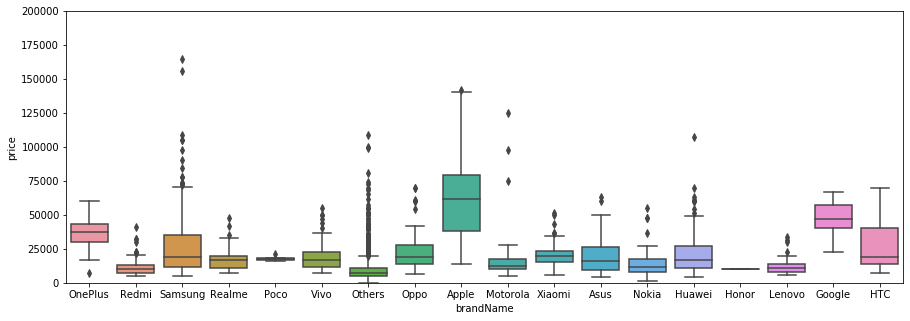

In [42]:
cat_col_box_plot(colName='brandName', figSize=(15,5))

In [43]:
mobile_df = mobile_df[~((mobile_df.brandName=='OnePlus')&(mobile_df.price<20000))]

In [44]:
mobile_df = mobile_df[~((mobile_df.brandName=='Others')&(mobile_df.price>75000))]

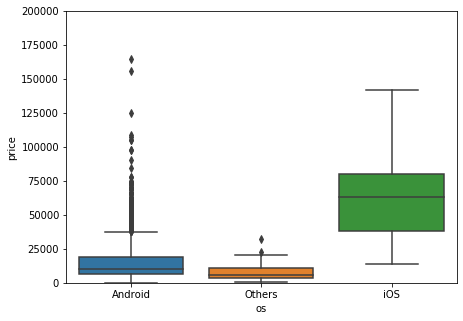

In [45]:
cat_col_box_plot(colName='os', figSize=(7,5))

In [46]:
mobile_df = mobile_df[~((mobile_df.os=='Others')&(mobile_df.price>20000))]

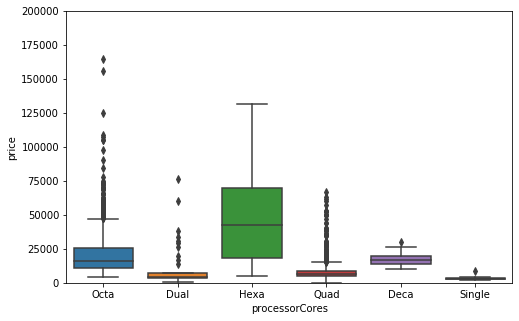

In [47]:
cat_col_box_plot('processorCores', (8,5))

In [48]:
mobile_df = mobile_df[~((mobile_df.processorCores=='Single')&(mobile_df.price>5000))]

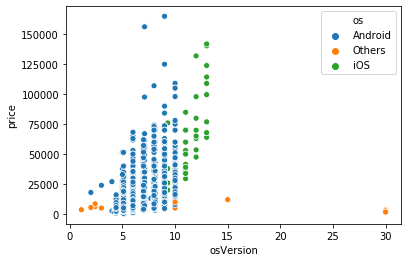

In [49]:
sns.scatterplot(mobile_df.osVersion, mobile_df.price, hue=mobile_df.os)

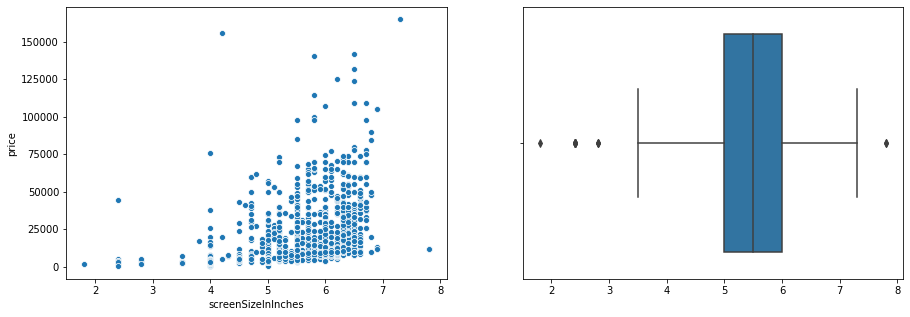

In [50]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(mobile_df.screenSizeInInches, mobile_df.price, ax=ax[0])
sns.boxplot([mobile_df.screenSizeInInches], ax=ax[1])

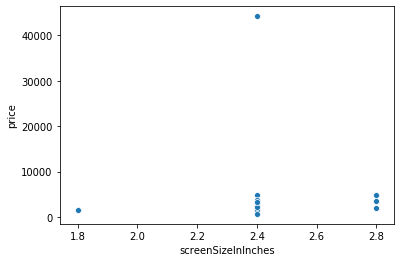

In [51]:
screensize_3 = mobile_df[mobile_df.screenSizeInInches<=3]
sns.scatterplot(screensize_3.screenSizeInInches, screensize_3.price)

In [52]:
mobile_df = mobile_df[~((mobile_df.screenSizeInInches<=3)&(mobile_df.price>10000))]

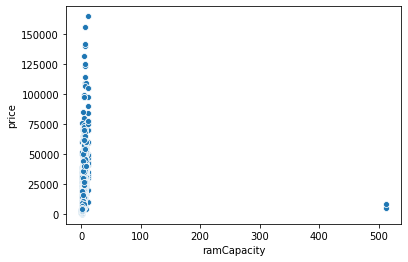

In [53]:
sns.scatterplot(x='ramCapacity', y="price", data=mobile_df)

In [54]:
mobile_df = mobile_df[~(mobile_df.ramCapacity>400)]

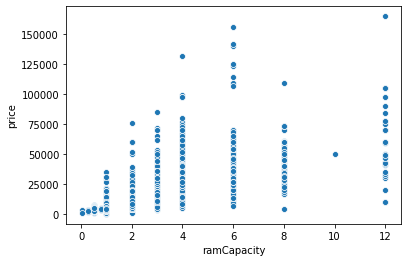

In [55]:
fig = sns.scatterplot(mobile_df.ramCapacity, mobile_df.price)

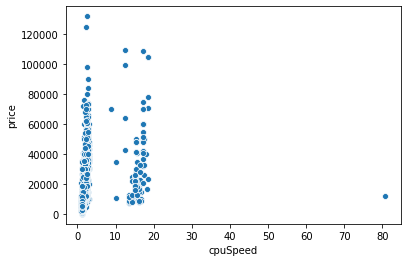

In [56]:
sns.scatterplot(mobile_df.cpuSpeed, mobile_df.price)

In [57]:
mobile_df = mobile_df[~(mobile_df.cpuSpeed>30)]

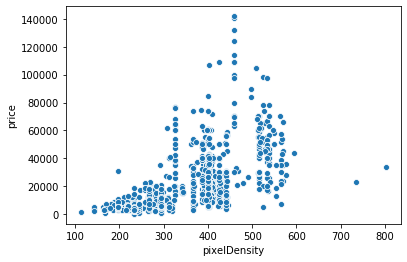

In [58]:
sns.scatterplot(mobile_df.pixelDensity, mobile_df.price)

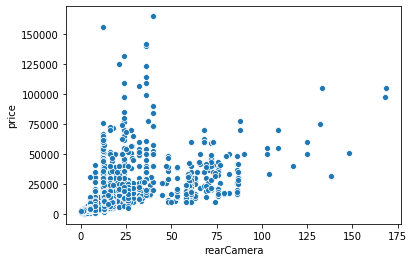

In [59]:
sns.scatterplot(mobile_df.rearCamera, mobile_df.price)

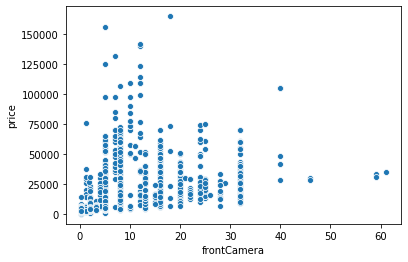

In [60]:
sns.scatterplot(mobile_df.frontCamera, mobile_df.price)

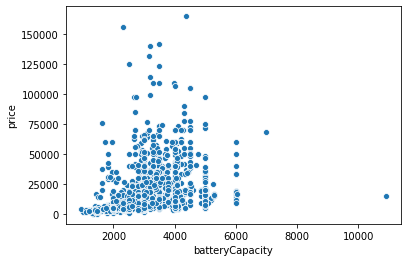

In [61]:
sns.scatterplot(mobile_df.batteryCapacity, mobile_df.price)

In [62]:
mobile_df = mobile_df[~(mobile_df.batteryCapacity>8000)]

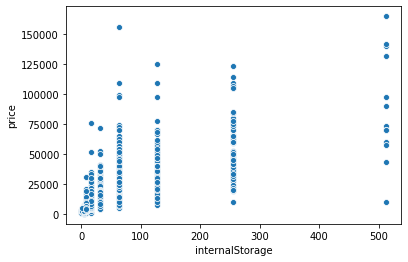

In [63]:
sns.scatterplot(mobile_df.internalStorage, mobile_df.price)

In [64]:
mobile_df = mobile_df[~((mobile_df.internalStorage>400)&(mobile_df.price<25000))]

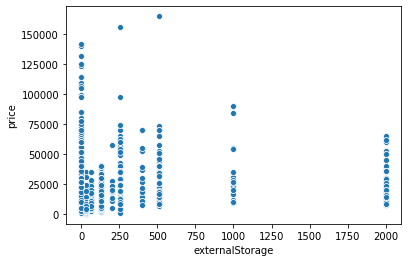

In [65]:
sns.scatterplot(mobile_df.externalStorage, mobile_df.price)

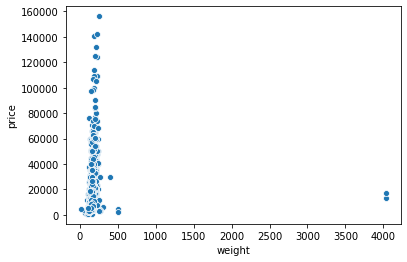

In [66]:
sns.scatterplot(mobile_df.weight, mobile_df.price)

In [67]:
mobile_df = mobile_df[~(mobile_df.weight>1000)]

In [68]:
brandName_cat = pd.Categorical(mobile_df.brandName, 
                                    categories = ['Samsung', 'Apple', 'Google', 'Huawei', 'OnePlus', 'Xiaomi',
                                                  'Redmi', 'Realme', 'Poco', 'Oppo', 'Vivo', 
                                                  'Asus', 'Nokia', 'Lenovo', 'HTC', 'Motorola', 
                                                  'Honor', ''], ordered=True)
brandName_cat_labels, _ = pd.factorize(brandName_cat, sort=True)
mobile_df.brandName = brandName_cat_labels

In [69]:
# Label encoding the brand name and os feature

label_encoder = LabelEncoder()

mobile_df['os'] = label_encoder.fit_transform(mobile_df['os'])

In [70]:
# binary encoding the fast charging 

mobile_df.fastCharging = mobile_df.fastCharging.map({'Yes':1, 'No':0})

In [71]:
# Ordinal encoding the processorCores

processor_core_cat = pd.Categorical(mobile_df.processorCores, 
                                    categories = ['Deca', 'Octa', 'Hexa', 'Quad', 'Dual', 'Single'], ordered=True)
processor_core_labels, _ = pd.factorize(processor_core_cat, sort=True)
mobile_df.processorCores = processor_core_labels

mobile_df.processorCores = mobile_df.processorCores.replace(to_replace=-1, value=np.nan)

In [72]:
for col in ['brandName', 'os', 'fastCharging', 'processorCores']:
    mobile_df[col] = mobile_df[col].astype('category')

In [73]:
mobile_df_imputed = mobile_df.copy(deep=True)

In [74]:
knn_imputer = KNN()
mobile_df_imputed = knn_imputer.fit_transform(mobile_df_imputed)

Imputing row 1/2209 with 0 missing, elapsed time: 0.691
Imputing row 101/2209 with 0 missing, elapsed time: 0.693
Imputing row 201/2209 with 1 missing, elapsed time: 0.694
Imputing row 301/2209 with 2 missing, elapsed time: 0.695
Imputing row 401/2209 with 3 missing, elapsed time: 0.697
Imputing row 501/2209 with 0 missing, elapsed time: 0.698
Imputing row 601/2209 with 0 missing, elapsed time: 0.700
Imputing row 701/2209 with 0 missing, elapsed time: 0.701
Imputing row 801/2209 with 1 missing, elapsed time: 0.702
Imputing row 901/2209 with 0 missing, elapsed time: 0.704
Imputing row 1001/2209 with 0 missing, elapsed time: 0.706
Imputing row 1101/2209 with 0 missing, elapsed time: 0.708
Imputing row 1201/2209 with 1 missing, elapsed time: 0.710
Imputing row 1301/2209 with 2 missing, elapsed time: 0.712
Imputing row 1401/2209 with 0 missing, elapsed time: 0.714
Imputing row 1501/2209 with 0 missing, elapsed time: 0.716
Imputing row 1601/2209 with 0 missing, elapsed time: 0.718
Imputing 

In [75]:
mobile_df = pd.DataFrame(mobile_df_imputed, columns=mobile_df.columns)

In [76]:
mobile_df_int = mobile_df[['brandName', 'os', 'fastCharging', 'processorCores', 'pixelDensity', 'batteryCapacity', 
                           'weight', 'price']].apply(lambda x: x.astype(int))
mobile_float = mobile_df.drop(['brandName', 'os', 'fastCharging', 'processorCores', 'pixelDensity', 'batteryCapacity', 
                               'weight', 'price'], axis=1)
mobile_df = pd.concat([mobile_float, mobile_df_int], axis=1)

# Model Building

In [77]:
mobile_final_df = mobile_df.copy(deep=True)

In [78]:
mobile_final_df.head()

,osVersion,screenSizeInInches,rearCamera,frontCamera,cpuSpeed,ramCapacity,internalStorage,externalStorage,brandName,os,fastCharging,processorCores,pixelDensity,batteryCapacity,weight,price
0,10.0,6.4,63.0,32.0,15.4,8.0,128.0,0.0,4,0,1,1,402,4115,184,27999
1,10.0,6.4,63.0,32.0,15.4,6.0,64.0,0.0,4,0,1,1,402,4115,184,24999
2,10.0,6.4,63.0,32.0,15.4,12.0,256.0,0.0,4,0,1,1,402,4115,184,29999
3,10.0,6.6,63.0,16.0,15.4,6.0,128.0,0.0,6,0,1,1,395,5020,209,16999
4,10.0,6.6,63.0,16.0,15.4,6.0,64.0,0.0,6,0,1,1,395,5020,209,13999


In [79]:
mobile_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2209 entries, 0 to 2208
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   osVersion           2209 non-null   float64
 1   screenSizeInInches  2209 non-null   float64
 2   rearCamera          2209 non-null   float64
 3   frontCamera         2209 non-null   float64
 4   cpuSpeed            2209 non-null   float64
 5   ramCapacity         2209 non-null   float64
 6   internalStorage     2209 non-null   float64
 7   externalStorage     2209 non-null   float64
 8   brandName           2209 non-null   int32  
 9   os                  2209 non-null   int32  
 10  fastCharging        2209 non-null   int32  
 11  processorCores      2209 non-null   int32  
 12  pixelDensity        2209 non-null   int32  
 13  batteryCapacity     2209 non-null   int32  
 14  weight              2209 non-null   int32  
 15  price               2209 non-null   int32  
dtypes: flo

In [80]:
for col in ['brandName', 'os', 'fastCharging', 'processorCores']:
    mobile_final_df[col] = mobile_final_df[col].astype('category')

In [81]:
mobile_final_df.shape

(2209, 16)

In [82]:
shuffled_df = mobile_final_df.sample(frac=1)

In [83]:
y = np.log(shuffled_df.price)
X = shuffled_df.drop(['price'], axis=1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [85]:
def get_rmse(y_act, y_pred):
    return  np.sqrt(mean_squared_error(y_act, y_pred))

rmse = make_scorer(get_rmse)

In [86]:
def get_scores(pred, test):
    print('Mean Absolute Error (MAE):', mean_absolute_error(pred, test))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(pred, test)))

**Random Forest Model**

In [87]:
for estimator in range(50, 1000, 50):
    random_forest = RandomForestRegressor(n_estimators= estimator)
    print("No of estimators " + str(estimator) + ": " + 
          str(round(np.mean(cross_val_score(random_forest, X=X_train, y=y_train, cv=5, scoring=rmse, n_jobs=-1)),4)))

No of estimators 50: 0.3793
No of estimators 100: 0.3769
No of estimators 150: 0.3751
No of estimators 200: 0.3757
No of estimators 250: 0.3757
No of estimators 300: 0.3757
No of estimators 350: 0.3766
No of estimators 400: 0.3754
No of estimators 450: 0.3742
No of estimators 500: 0.3754
No of estimators 550: 0.3747
No of estimators 600: 0.3751
No of estimators 650: 0.3756
No of estimators 700: 0.3753
No of estimators 750: 0.3753
No of estimators 800: 0.3746
No of estimators 850: 0.3751
No of estimators 900: 0.3753
No of estimators 950: 0.3754


In [88]:
random_forest = RandomForestRegressor(n_estimators=450, random_state=402)
best_random_forest = GridSearchCV(random_forest, param_grid={'max_depth':[6,12,20], 'bootstrap':[True, False],
                                                             'min_samples_split':[2,10,90], 'min_samples_leaf':[1,3,6,10],
                                                             'max_features':[None, 'sqrt', 'log2']}, 
                                  scoring='neg_mean_squared_error', n_jobs=-1, cv=5)

In [89]:
best_random_forest.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=450,
                                             random_state=402),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [6, 12, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 6, 10],
                         'min_samples_split': [2, 10, 90]},
             scoring='neg_mean_squared_error')

In [90]:
best_random_forest.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [91]:
cross_val_score(best_random_forest.best_estimator_, X_train, y_train, scoring=rmse, n_jobs=-1)

array([0.36067684, 0.35094643, 0.4004564 , 0.35137318, 0.35136678])

In [93]:
final_rf_model = RandomForestRegressor(n_estimators=450, max_depth=20, min_samples_split=10, max_features='sqrt',
                                       oob_score=True, n_jobs=-1)

In [94]:
final_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=10,
                      n_estimators=450, n_jobs=-1, oob_score=True)

In [95]:
final_rf_model.score(X_test, y_test)

0.8304787590756412

In [96]:
feature_imp = pd.Series(final_rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp

pixelDensity          0.192784
cpuSpeed              0.153495
internalStorage       0.130998
ramCapacity           0.118190
rearCamera            0.108216
screenSizeInInches    0.045087
frontCamera           0.044760
batteryCapacity       0.039671
brandName             0.034506
weight                0.033830
processorCores        0.032620
osVersion             0.029264
externalStorage       0.020050
os                    0.011416
fastCharging          0.005114
dtype: float64

In [97]:
rf_predictions = final_rf_model.predict(X_test)

In [98]:
get_scores(pred=rf_predictions, test=y_test)

Mean Absolute Error (MAE): 0.2555539876670692
Root Mean Squared Error (RMSE): 0.3638146560900438


**Gradient Boosting Machine**

In [99]:
gbm = GradientBoostingRegressor()
best_gbm = GridSearchCV(gbm, param_grid={'n_estimators':[750,1200,2000], 'learning_rate':[0.01, 0.03, 0.06, 0.1]}, 
                        n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

In [100]:
best_gbm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.06, 0.1],
                         'n_estimators': [750, 1200, 2000]},
             scoring='neg_mean_squared_error')

In [101]:
best_gbm.best_params_

{'learning_rate': 0.03, 'n_estimators': 750}

In [102]:
cross_val_score(best_gbm.best_estimator_, X_train, y_train, scoring=rmse, cv=5, n_jobs=-1)

array([0.37522373, 0.3550392 , 0.40530308, 0.34316586, 0.34860426])

In [103]:
gbm = GradientBoostingRegressor(n_estimators=750, learning_rate=0.03, random_state=402)
best_gbm = GridSearchCV(gbm, param_grid={'min_samples_split':[2,10,90], 'min_samples_leaf':[1,3,6,10], 'max_depth':[2,3]}, 
                        n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

In [104]:
best_gbm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.03,
                                                 n_estimators=750,
                                                 random_state=402),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3], 'min_samples_leaf': [1, 3, 6, 10],
                         'min_samples_split': [2, 10, 90]},
             scoring='neg_mean_squared_error')

In [105]:
best_gbm.best_params_

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [106]:
cross_val_score(best_gbm.best_estimator_, X_train, y_train, scoring=rmse, cv=5, n_jobs=-1)

array([0.37451056, 0.35530105, 0.40569224, 0.34334231, 0.34893813])

In [107]:
final_gbm = GradientBoostingRegressor(n_estimators=750, learning_rate=0.03, random_state=402)

In [108]:
final_gbm.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.03, n_estimators=750,
                          random_state=402)

In [109]:
final_gbm.score(X_test, y_test)

0.8306297397861054

In [110]:
gbm_predictions = final_gbm.predict(X_test)

In [111]:
get_scores(pred=gbm_predictions, test=y_test)

Mean Absolute Error (MAE): 0.257819754097159
Root Mean Squared Error (RMSE): 0.3636526078689566


**Xtreme Gradient Boosting Machine**

In [113]:
xgbm_df = mobile_df.copy(deep=True)

In [116]:
for col in ['brandName', 'os', 'fastCharging', 'processorCores']:
    xgbm_df[col] = xgbm_df[col].astype('category')

In [119]:
dummies = pd.get_dummies(data=xgbm_df, columns=['brandName', 'os', 'fastCharging', 'processorCores'])

In [121]:
shuffled_df = dummies.sample(frac=1)

In [122]:
y = np.log(shuffled_df.price)
X = shuffled_df.drop(['price'], axis=1)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [126]:
xgbm = xgbr()
best_xgbm = GridSearchCV(xgbm, param_grid={'n_estimators':[500,750,1200,2000], 'learning_rate':[0.001,0.01, 0.03, 0.06, 0.1]}, 
                        n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

In [127]:
best_xgbm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [128]:
best_xgbm.best_params_

{'learning_rate': 0.01, 'n_estimators': 750}

In [161]:
cross_val_score(best_xgbm.best_estimator_, X_train, y_train, scoring=rmse, cv=5, n_jobs=-1)

array([0.35052527, 0.37345151, 0.36781656, 0.38730235, 0.33943315])

In [167]:
xgbm = xgbr(n_estimators=750, learning_rate=0.01)
best_xgbm = GridSearchCV(xgbm, param_grid={'min_child_weight':[1,0.01,0.1,5],'max_depth':[2,3,4,6,12,18], 'gamma':[0.001, 0.01, 0.1, 5, 10]}, 
                        n_jobs=-1, scoring='neg_mean_squared_error', cv=5)

In [168]:
best_xgbm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.01, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=750, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [169]:
best_xgbm.best_params_

{'gamma': 0.1, 'max_depth': 6, 'min_child_weight': 1}

In [170]:
best_xgbm.best_score_

-0.13256819745604137

In [171]:
cross_val_score(best_xgbm.best_estimator_, X_train, y_train, scoring=rmse, cv=5, n_jobs=-1)

array([0.35052527, 0.37345151, 0.36781656, 0.38730235, 0.33943315])

In [172]:
final_xgbm = xgbr(n_estimators=750, learning_rate=0.01, gamma=0.1, max_depth=6, min_child_weight=1,
                  random_state=402)

In [173]:
final_xgbm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=0, num_parallel_tree=1, random_state=402,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [174]:
final_xgbm.score(X_test, y_test)

0.7933419730778093

In [175]:
xgbm_predictions = final_xgbm.predict(X_test)

In [176]:
get_scores(pred=xgbm_predictions, test=y_test)

Mean Absolute Error (MAE): 0.25824488621903363
Root Mean Squared Error (RMSE): 0.3579631724264337
